In [2]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
import os

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import label_binarize



from scipy.stats import mannwhitneyu    
from xgboost import XGBClassifier
import random
from sklearn.model_selection import KFold


# caculating_10_important_features
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
# sig_data = DATA.reshape(DATA.shape[0], -1)
def train_model_using_kfold(data, label, model, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True)
    result = []

    # Loop over each train/test split
    for train_index, test_index in kf.split(data):
        # Split the data into training and testing sets
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = label[train_index], label[test_index]

        # Train the classifier
        model.fit(X_train, y_train)

        # Predict the label for the test set
        y_pred = model.predict(X_test)

        # Append the accuracy to the list
        result.append([y_pred, y_test])

    return np.array(result)


def train_model_using_loocv(data, label, model):
    loo = LeaveOneOut()
    result = []

    # Loop over each train/test split
    for train_index, test_index in loo.split(data):
        # Split the data into training and testing sets
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = label[train_index], label[test_index]

        # Train the classifier
        model.fit(X_train, y_train)

        # Predict the label for the test set
        y_pred = model.predict(X_test)

        # Append the accuracy to the list
        result.append([y_pred, y_test])

    return np.array(result), model

stats_method = 'mannwhitneyu' # 'ranksums' or 'mannwhitneyu'
def zero_diagnonal(arr):
    # Loop over the first and last dimension
    for i in range(arr.shape[0]):  # Loop over subjects
        for j in range(arr.shape[-1]):  # Loop over views
            np.fill_diagonal(arr[i, :, :, j], 0)
    return arr


def return_significant_FCvalue(adj, labels):
    adj = zero_diagnonal(adj)
    hc_adj = adj[np.where(labels==1)]
    md_adj = adj[np.where(labels==0)]
    count = 0

    num_view = adj.shape[-1]
    p_view = np.zeros((52,52,num_view))
    effect_size = np.zeros((52,52,num_view))
    stats = np.zeros((52,52,num_view))
    for view in range(num_view):
        for seed in range(52):
            for target in range(52):
                hc_val = hc_adj[:, seed, target, view]
                md_val = md_adj[:, seed, target, view]
                if stats_method == 'mannwhitneyu':
                    stat, p1 = mannwhitneyu(hc_val,md_val)

                else:
                    raise ValueError('stats_method should be mannwhitneyu or ranksums')
                p_view[seed, target, view] = p1
                stats[seed, target, view] = stat
    
    adj = adj.reshape(adj.shape[0], -1)
    p_view = p_view.reshape(-1)
    return adj[:, p_view<0.05]

def get_activity_start_time(data, index_start):
    gradient = np.gradient(data)
    max_gradient = np.argmax(gradient[0:int(index_start*1.2)])  # 0:index_start*4 # current index_start = 400,
    if max_gradient <= index_start:
        max_gradient = index_start
    return max_gradient


"""
Calulate the left slope based on the data sample time from activity_start_time and  activity_start_time + task_duration//2
"""


def get_left_slope(data, activity_start, task_duration):
    activity_start = int(activity_start)
    data = data[activity_start: activity_start+task_duration//2]
    slope, _ = np.polyfit(np.arange(data.shape[0]), data, 1)
    return slope


"""
Calulate the right slope based on the data sample time from activity_start_time + task_duration//2 and activity_start_time + task_duration  
"""


def get_right_slope(data, activity_start, task_duration):
    activity_start = int(activity_start)
    data = data[activity_start+task_duration//2: activity_start+task_duration]
    slope, _ = np.polyfit(np.arange(data.shape[0]), data, 1)
    return slope


"""
For calculating FWHM
"""


def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx


def get_FWHM(y_values, activity_start, task_duration):
    # make sure the peak value is situated in the task duration period
    task = y_values[activity_start:activity_start+task_duration]
    max_task = np.max(task)  # Find the maximum y value
    half_max_y = max_task / 2.0
    max_index_task = np.argmax(task)
    # if max_index_task is in the first two values, set left_index to 0
    if max_index_task <= 1:
        left_index = 0
    else:
        left_index = find_nearest(y_values[:max_index_task], half_max_y)
    # if max_index_task is in the last two values, set right_index to the last value
    if max_index_task >= activity_start+task_duration-1:
        right_index = task_duration-1
    else:
        right_index = find_nearest(
            y_values[max_index_task:], half_max_y) + max_index_task

    return right_index - left_index


"""Get all 10 features"""


def get_10_features(hbo, index_start, task_duration):
    feature_shape = hbo.shape[:2]
    # Feature 1 mean
    mean = np.mean(hbo, axis=2)  # feature shape is (subject, channel)

    # Feature 2 variance
    variance = np.std(hbo, axis=2)  # feature shape is (subject, channel)

    # Feature 3 activity_start_time
    activity_start_time = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            activity_start_time[sub, ch] = get_activity_start_time(
                hbo[sub, ch], index_start=index_start)

    # # Feature 4 left_slope
    left_slope = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            left_slope[sub, ch] = get_left_slope(
                hbo[sub, ch], activity_start=activity_start_time[sub, ch], task_duration=task_duration)
    # # Feature 5  right_slope
    right_slope = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            right_slope[sub, ch] = get_right_slope(
                hbo[sub, ch], activity_start=activity_start_time[sub, ch], task_duration=task_duration)

    # # Feature 6 kurtosis
    kurt = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            kurt[sub, ch] = kurtosis(hbo[sub, ch])
    # There might be some nan in kurtosis calucaltion because of all 0-value array
    kurt = np.nan_to_num(kurt)

    # # Feature 7 skewness
    skewness = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            skewness[sub, ch] = skew(hbo[sub, ch])
    # There might be some nan in skewness calucaltion because of all 0-value array
    skewness = np.nan_to_num(skewness)

    # # Feature 8 area under the curve AUC Based on the sample time from activity_start_time + task_duration
    AUC = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            activity_start = int(activity_start_time[sub, ch])
            AUC[sub, ch] = np.sum(
                hbo[sub, ch][activity_start:activity_start+task_duration])
    # for sub in range(10):
    #     plt.plot(AUC[sub])

    # # Feature 9 full width half maximum (FWHM)
    # FWHM
    FWHM = np.empty_like(mean)
    for sub in range(feature_shape[0]):
        for ch in range(feature_shape[1]):
            activity_start = int(activity_start_time[sub, ch])
            FWHM[sub, ch] = get_FWHM(
                hbo[sub, ch], activity_start, task_duration)
    # for sub in range(10):
    #     plt.plot(FWHM[sub])

    # # Feature 10 peak
    peak = np.max(hbo, axis=2)

    features = np.concatenate((mean, variance, activity_start_time,
                              left_slope, right_slope, kurt, skewness, AUC, FWHM, peak), axis=1)

    return features

def get_significant_feature(data, labels):
    hc_adj = data[np.where(labels==1)]
    md_adj = data[np.where(labels==0)]
    count = 0

    p_view = np.zeros((hc_adj.shape[1:]))
    for view in range(p_view.shape[-1]):
        hc_val = hc_adj[:, view]
        mdd_val = md_adj[:, view]
        _, p1 = mannwhitneyu(hc_val,mdd_val)
        p_view[view] = p1
    data = data.reshape(data.shape[0], -1)
    p_view = p_view.reshape(-1)
    data = data[:, p_view<0.05]
    return data 


def get_metrics(y_true, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # 明确指定labels参数
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # 现在cm是一个2x2矩阵，即使数据只包含一个类别
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred)

    return accuracy, sensitivity, specificity, f1

def print_md_table(model_name, set, metrics):
    print()
    print('| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |')
    print('|------------|----------|----------|-------------|-------------|----------|')
    print(f'| {model_name} | {set} |', end = '')
    for i in range(4):
        print(f" {metrics[i]:.4f} |", end = '')
    print()
def individual_normalization(data):
    for i in range(data.shape[0]):
        data[i] = (data[i] - np.mean(data[i])) #/ np.std(data[i])
    return data

In [9]:

output_fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/results/ML_results'
if not os.path.exists(output_fold):
    os.makedirs(output_fold)




res = {}

# 初始化模型，同时设置随机种子
models = {
    # "Logistic Regression": LogisticRegression(max_iter=150),
    "Decision Tree": DecisionTreeClassifier(),
    # "Random Forest": RandomForestClassifier(),
    # "SVM": SVC(),
}
for name, model in models.items():
    # run multiple time, using different time stamp as random seed
    for num_time in range(1):
        print(f'current training {name}, num_time: {num_time}')

        # 使用当前时间戳作为随机种子
        current_time_seed = 1706166341

        # build model
        model.random_state = current_time_seed

        hb_result = {}
        HB_TYPE_accuraies = {}
        HB_TYPE_y_pred_and_y_test = {}
        for HB_TYPE in ['HbO', 'HbR', 'HbT']:
            HB_TYPE_accuraies[HB_TYPE] = []
            HB_TYPE_y_pred_and_y_test[HB_TYPE] = []

            # read data
            fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/diagnosis'

            hb = np.load(fold + '/hb_data.npy')
            hb = np.nan_to_num(hb)
            label = np.load(fold + '/label.npy')

            if HB_TYPE == 'HbO':
                hb = hb[..., 0]
            elif HB_TYPE == 'HbR':
                hb = hb[..., 1]
            else:
                hb = hb[..., 2]
            hb_2d = np.reshape(hb, (hb.shape[0], -1))

            # Apply LOOCV to train the model
            # Initialize LeaveOneOut
            loo = LeaveOneOut()

            # 存储每个模型的准确率
            accuracies = {}

            # Loop over each train/test split
            for train_index, test_index in loo.split(hb_2d):
                # Split the data into training and testing sets
                X_train, X_test = hb_2d[train_index], hb_2d[test_index]
                y_train, y_test = label[train_index], label[test_index]

                # Train the classifier
                model.fit(X_train, y_train)

                # Predict the label for the test set
                y_pred = model.predict(X_test)

                # Calculate the accuracy for the current fold
                accuracy = accuracy_score(y_test, y_pred)

                # Append the accuracy to the list
                HB_TYPE_accuraies[HB_TYPE].append(accuracy)

                HB_TYPE_y_pred_and_y_test[HB_TYPE].append([y_pred, y_test])
            accuracies[HB_TYPE] = 1
            accuracies[HB_TYPE] = np.mean(HB_TYPE_accuraies[HB_TYPE])

        save_result = {}
        save_result['accuracies'] = accuracies
        save_result['model_accuraies'] = HB_TYPE_accuraies
        save_result['current_time_seed'] = current_time_seed
        save_result['num_time'] = num_time
        save_result['HB_TYPE_y_pred_and_y_test'] = HB_TYPE_y_pred_and_y_test

        res[f'{num_time}'] = save_result
    # np.save(output_fold + f'/{name}_result_validate.npy', res)

current training Decision Tree, num_time: 0


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score


for hb_type in ['HbO', 'HbR', 'HbT']:
    res_true_pred = np.array(save_result['HB_TYPE_y_pred_and_y_test'][hb_type])

    y_true = res_true_pred[:, 1]
    y_pred = res_true_pred[:, 0]

    res_metrics = get_metrics(y_true, y_pred)
    print_md_table('Decision Tree', 'test' + hb_type, res_metrics)



| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | testHbO | 0.6714 | 0.6000 | 0.7429 | 0.6462 |

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | testHbR | 0.4714 | 0.3429 | 0.6000 | 0.3934 |

| Model Name |   Set   |Accuracy | Sensitivity | Specificity | F1 Score |
|------------|----------|----------|-------------|-------------|----------|
| Decision Tree | testHbT | 0.5857 | 0.6000 | 0.5714 | 0.5915 |


(52, 125)


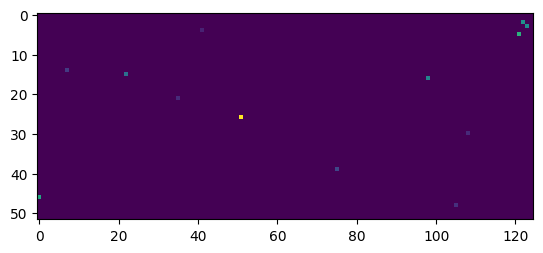

In [12]:
# Assuming you have already trained the model and stored it in the variable 'model'

# Get the feature importances
feature_importances = model.feature_importances_
feature_importances = feature_importances.reshape(52, -1)
feature_importances = np.reshape(feature_importances[:,:1250], (52, -1, 10))
feature_importances = np.mean(feature_importances, axis=-1)
print(feature_importances.shape)
plt.imshow(feature_importances)

In [14]:
np.argmax(feature_importances)/52

63.48076923076923

In [3]:
# read data 
RS_FC = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/diagnosis/fc_data.npy')
LABEL = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/diagnosis/label.npy')
HB = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/diagnosis/hb_data.npy')

HB = individual_normalization(HB)
        


from scipy.stats import zscore
demographic_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/diagnosis/demographic_data.npy'
demo_data = np.load(demographic_path)
demo_data_normalized = zscore(demo_data, axis=0)
deleted_demo_data_normalized = np.delete(demo_data_normalized, 6, axis=1)




hbo_10_features = get_10_features(HB[..., 0], 100, 600)
hbr_10_features = get_10_features(HB[..., 1], 100, 600)
hbt_10_features = get_10_features(HB[..., 2], 100, 600)
# get the significant data 
significant_FC = return_significant_FCvalue(RS_FC, LABEL)
sig_hbo_feature = get_significant_feature(hbo_10_features, LABEL)
sig_hbr_feature = get_significant_feature(hbr_10_features, LABEL)
sig_hbt_feature = get_significant_feature(hbt_10_features, LABEL)

sig_hb = np.concatenate((sig_hbo_feature, sig_hbr_feature, sig_hbt_feature), axis=1)


sig_data = np.concatenate((significant_FC, sig_hb), axis=1)
sig_demographic_fc = np.concatenate((demo_data_normalized, significant_FC), axis=1)
# using XGBoost to train the model

# show the result 


/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_70317/2961210513.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt[sub, ch] = kurtosis(hbo[sub, ch])
/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_70317/2961210513.py:214: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness[sub, ch] = skew(hbo[sub, ch])


In [117]:
sig_demographic_fc = np.concatenate((deleted_demo_data_normalized, significant_FC), axis=1)


In [ ]:

while True:
    learning_rate = random.uniform(0.1, 0.6)
    n_estimators = np.random.choice([1,5,50,100,200,500,1000])
    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=20,
        reg_alpha=10,
        reg_lambda=15,
        n_estimators= n_estimators,
    )
# 存储每个模型的准确率
    result,model = train_model_using_loocv(significant_FC.reshape(significant_FC.shape[0],-1), LABEL, model)
    res_metrics = get_metrics(result[:, 1], result[:, 0])
    
    # result = train_model_using_kfold(deleted_demo_data_normalized, LABEL, model)
    # res_metrics = kfold_get_metrics(result)
    print(f'learning_rate: {learning_rate}, n_estimators: {n_estimators}')
    print_md_table('Decision Tree', 'test', res_metrics)
    # break

In [88]:
feature_importances = model.feature_importances_
print("特征重要性：", feature_importances)

demographic_name = np.array([
    ['Age (years)', 'Sex', 'Ethnicity', 'Handedness', 'Education (years)', 
    'Current/highest education level —  Coded', 'Perceived social support', 
    'Past trauma', 'Current psychiatric comorbidities — Binary', 
    'Current psychiatric comorbidities — Coded', 'Family history of psychiatric illness']
])

for i,v in enumerate(feature_importances):
    print('Feature: %s, Score: %.5f, %0d' % (demographic_name[0][i],v,i))


特征重要性： [0.00734201 0.         0.         0.29543024 0.         0.16029395
 0.01750298 0.44857877 0.         0.07085204]
Feature: Age (years), Score: 0.00734, 0
Feature: Sex, Score: 0.00000, 1
Feature: Ethnicity, Score: 0.00000, 2
Feature: Handedness, Score: 0.29543, 3
Feature: Education (years), Score: 0.00000, 4
Feature: Current/highest education level —  Coded, Score: 0.16029, 5
Feature: Perceived social support, Score: 0.01750, 6
Feature: Past trauma, Score: 0.44858, 7
Feature: Current psychiatric comorbidities — Binary, Score: 0.00000, 8
Feature: Current psychiatric comorbidities — Coded, Score: 0.07085, 9


In [32]:
def kfold_get_metrics(result):
    folds_result = []
    for i in range(len(result)):
        x = get_metrics(result[i,1], result[i,0])
        folds_result.append(x)

    folds_result = np.array(folds_result)
    folds_result = np.mean(folds_result, axis=0)
    return folds_result